In [1]:
#all my imports
#!pip install netCDF4
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import calendar
from netCDF4 import Dataset
from datetime import datetime
import cmocean as cm
import xarray as xr
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d

In [2]:
os.chdir(r"C:/Users/lydia/Seagliders/tropics_mission/tropics_data") # sets my working directory

In [3]:
# open the seaglider dataset and set up the coordinates
sg_df = xr.open_dataset('sg195_MOTIVE_2024_timeseries.nc') 
sg_df = sg_df.set_coords("latitude")
sg_df = sg_df.set_coords("longitude")
sg_df = sg_df.set_coords("depth")

# Extract variables
lat = np.array(sg_df['latitude'])
lon = np.array(sg_df['longitude'])
temp = np.array(sg_df['temperature'])
salinity = np.array(sg_df['salinity'])
depth = np.array(sg_df['depth'])
sg_df['new_time'] = pd.to_datetime(sg_df['time']) + pd.DateOffset(years=19, months=7, days=14) # fixes the date of the data
time = np.array(sg_df['new_time'])
sg_months = pd.to_datetime(time).month # allows me to distinguish the month that the data is from 


In [5]:
# my historic data sets were broken up into two parts so I imported them like this and made a function to process them the same way
historic_ds1 = xr.open_dataset('ocldb1746576816.2520367_CTD.nc', decode_timedelta = False)
historic_ds2 = xr.open_dataset('ocldb1746576816.2520367_OSD.nc', decode_timedelta = False)

C:\Users\lydia\AppData\Local\Temp\ipykernel_224\2905960551.py:103: RuntimeWarning: Mean of empty slice
  mean_profile = np.nanmean(profiles, axis=0)
C:\Users\lydia\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


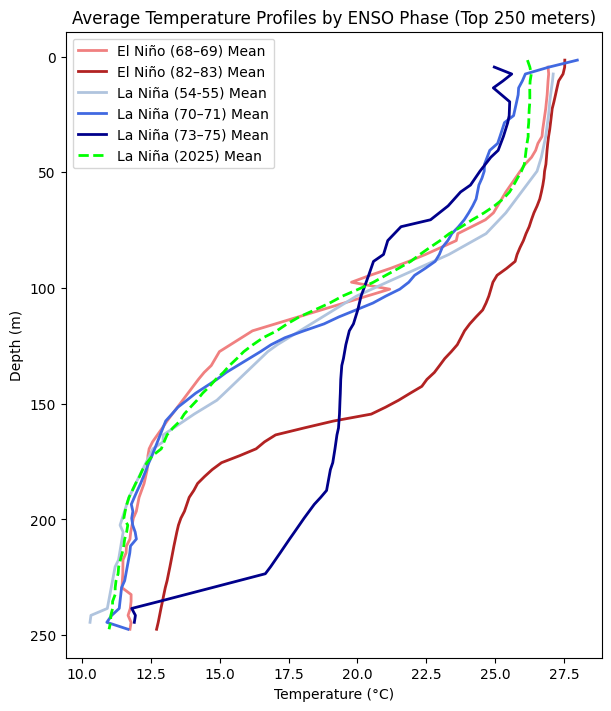

In [10]:
# TEMPERATURE

# define my function because I am plotting with multiple historic files
# I am able to give the function these four inputs and it processes and groups the files for me
def process_profiles(season_ds, year_groups, colors, profile_groups):
    cast_lats = season_ds['lat'].values
    cast_ids = season_ds['casts'].values
    season_ds = season_ds.sel(casts=cast_ids)

    row_sizes = season_ds['Temperature_row_size'].values # the amount of temperature values in each cast varied so I had to set up to find the row size and take that many data points
    start_idx = 0

    depth_cast_bins = np.arange(0, 250, 3) #bin depths because values vary
    depth_midpoints = (depth_cast_bins[:-1] + depth_cast_bins[1:]) / 2 # this just makes plotting easier/look better

    for cast_num, cast_id in enumerate(season_ds['casts']):  # because temperature row size varies this loop makes sure I am starting at the right index for each separate cast by adding up previous temp row size values
        cast_ds = season_ds.sel(casts=cast_id)
        temp_len = int(row_sizes[cast_num])
        temp_vals = season_ds['Temperature'].values[start_idx:start_idx + temp_len]
        depth_vals = season_ds['z'].values[start_idx:start_idx + temp_len]
        start_idx += temp_len

        # Skip casts where no depth values fall within the bin range
        if not np.any((depth_vals >= depth_cast_bins[0]) & (depth_vals <= depth_cast_bins[-1])):
            continue

        temp_cast = xr.DataArray(temp_vals, coords=[depth_vals], dims="depth")

        try:
            temp_binned = temp_cast.groupby_bins("depth", bins=depth_cast_bins).mean()
        except ValueError:
            continue  # in case something still gets through

        bins_cast = temp_binned["depth_bins"].values
        depth_new = np.array([interval.mid for interval in bins_cast])
        temp_new = temp_binned.values

        valid_mask = ~np.isnan(temp_new) #identifying nan values
        temp_clean = temp_new[valid_mask]
        depth_clean = depth_new[valid_mask]

        if len(temp_clean) > 3: # want at least three casts to make sure it is a good representation of the area
            interp_temp = np.interp(depth_midpoints, depth_clean, temp_clean, left=np.nan, right=np.nan)
            cast_time = pd.to_datetime(cast_ds['time'].values)
            cast_year = cast_time.year

            for label, years in year_groups.items():
                if cast_year in years:
                    profile_groups[label].append(interp_temp)

    return profile_groups



# apply to both datasets

months1 = historic_ds1['time'].dt.month
months2 = historic_ds2['time'].dt.month

# only want these specific months, added 9 for season_ds1 because it is in the same season and give a good example of a el nino
season_ds1 = historic_ds1.sel(casts=(months1.isin([9, 11, 12, 1, 2])))
season_ds2 = historic_ds2.sel(casts=(months2.isin([11, 12, 1, 2])))

# year groups and colors for legend
el_nino_years1 = [1968, 1969]
el_nino_years2 = [1982]
la_nina_years1 = [1954, 1955]
la_nina_years2 = [1970, 1971]
la_nina_years3 = [1973, 1974, 1975]

year_groups = {
    "El Niño (68–69)": el_nino_years1,
    "El Niño (82–83)": el_nino_years2,
    "La Niña (54-55)": la_nina_years1,
    "La Niña (70–71)": la_nina_years2,
    "La Niña (73–75)": la_nina_years3,
}

colors = {
    "El Niño (68–69)": "lightcoral",
    "El Niño (82–83)": "firebrick",
    "La Niña (54-55)": "lightsteelblue",
    "La Niña (70–71)": "royalblue",
    "La Niña (73–75)": "darkblue"
}

profile_groups = {label: [] for label in year_groups}

# process both filtered seasonal datasets
for season_ds in [season_ds1, season_ds2]:
    profile_groups = process_profiles(season_ds, year_groups, colors, profile_groups)

# now you can plot

plt.figure(figsize=(6, 7), constrained_layout=True)
depth_cast_bins = np.arange(0, 250, 3)
depth_midpoints = (depth_cast_bins[:-1] + depth_cast_bins[1:]) / 2

for label in profile_groups:
    profiles = np.array(profile_groups[label])
    if profiles.size == 0:
        continue
    mean_profile = np.nanmean(profiles, axis=0)
    std_profile = np.nanstd(profiles, axis=0)
    color = colors[label]

    plt.plot(mean_profile, depth_midpoints, label=f"{label} Mean", color=color, linewidth=2) # plots of the mean profile of all the selected casts for that year range and month range
    #plt.fill_betweenx(depth_midpoints, mean_profile - std_profile, mean_profile + std_profile, color=color, alpha=0.2, label=f"{label} ±1 STD") # std shading
    
depth_bins = np.arange(0, 250, 3)
temp_new = sg_df['temperature'].groupby_bins("depth", bins=depth_bins).mean()
bins = temp_new["depth_bins"].values
depth_new = np.array([interval.mid for interval in bins])
temp_array = temp_new.values


# plot mean profile of seaglider data
plt.plot(temp_array, depth_new, c='lime', linewidth=2, linestyle='--', label='La Niña (2025) Mean')

plt.gca().invert_yaxis()
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.legend()
plt.title("Average Temperature Profiles by ENSO Phase (Top 250 meters)") # this one shows just the top 250 but you can easily adjust to go deeper by changing the depth bins
plt.show()


C:\Users\lydia\AppData\Local\Temp\ipykernel_33472\2456209479.py:98: RuntimeWarning: Mean of empty slice
  mean_profile = np.nanmean(profiles, axis=0)
C:\Users\lydia\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.DataArray 'latitude' (sg_data_point: 366157)> Size: 1MB
array([0.732153, 0.732165, 0.732189, ..., 8.29    , 8.289982, 8.289973],
      shape=(366157,), dtype=float32)
Coordinates:
    depth      (sg_data_point) float32 1MB 0.9209 0.8609 ... 0.8908 -0.1101
    ctd_time   (sg_data_point) datetime64[ns] 3MB ...
    ctd_depth  (sg_data_point) float32 1MB ...
    latitude   (sg_data_point) float32 1MB 0.7322 0.7322 0.7322 ... 8.29 8.29
    longitude  (sg_data_point) float32 1MB -139.2 -139.2 ... -141.3 -141.3
Dimensions without coordinates: sg_data_point
Attributes:
    standard_name:  latitude
    axis:           Y
    units:          degrees_north
    comment:        Latitude of the sample based on hdm DAC


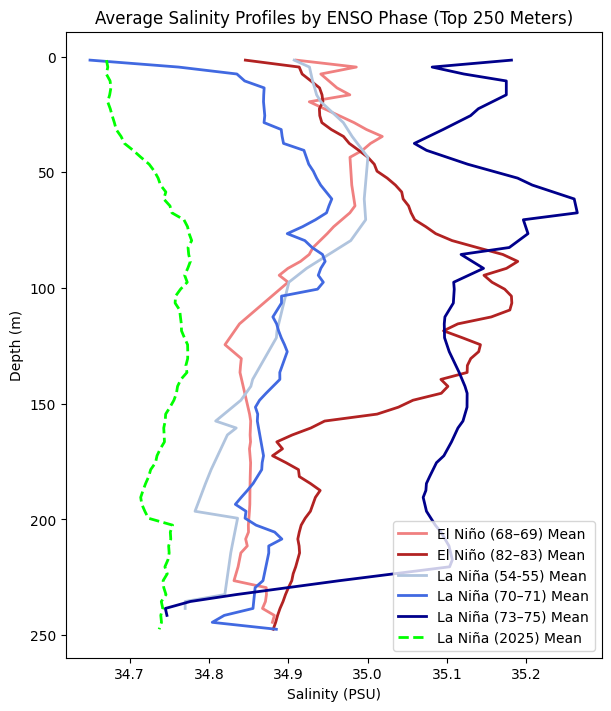

In [11]:
# SALINITY 
# this is the same as above but just for salinity (same code logic, different variable)
def process_profiles(season_ds, year_groups, colors, profile_groups):
    cast_lats = season_ds['lat'].values
    cast_ids = season_ds['casts'].values
    season_ds = season_ds.sel(casts=cast_ids)

    row_sizes = season_ds['Salinity_row_size'].values
    start_idx = 0

    depth_cast_bins = np.arange(0, 250, 3)
    depth_midpoints = (depth_cast_bins[:-1] + depth_cast_bins[1:]) / 2

    for cast_num, cast_id in enumerate(season_ds['casts']):
        cast_ds = season_ds.sel(casts=cast_id)
        sal_len = int(row_sizes[cast_num])
        sal_vals = season_ds['Salinity'].values[start_idx:start_idx + sal_len]
        depth_vals = season_ds['z'].values[start_idx:start_idx + sal_len]
        start_idx += sal_len

        # Skip casts where no depth values fall within the bin range
        if not np.any((depth_vals >= depth_cast_bins[0]) & (depth_vals <= depth_cast_bins[-1])):
            continue

        sal_cast = xr.DataArray(sal_vals, coords=[depth_vals], dims="depth")

        try:
            sal_binned = sal_cast.groupby_bins("depth", bins=depth_cast_bins).mean()
        except ValueError:
            continue  # in case an edge case still slips through

        bins_cast = sal_binned["depth_bins"].values
        depth_new = np.array([interval.mid for interval in bins_cast])
        sal_new = sal_binned.values

        valid_mask = ~np.isnan(sal_new)
        sal_clean = sal_new[valid_mask]
        depth_clean = depth_new[valid_mask]

        if len(sal_clean) > 3:
            interp_sal = np.interp(depth_midpoints, depth_clean, sal_clean, left=np.nan, right=np.nan)
            cast_time = pd.to_datetime(cast_ds['time'].values)
            cast_year = cast_time.year

            for label, years in year_groups.items():
                if cast_year in years:
                    profile_groups[label].append(interp_sal)

    return profile_groups


# apply to datasets

months1 = historic_ds1['time'].dt.month
months2 = historic_ds2['time'].dt.month

season_ds1 = historic_ds1.sel(casts=(months1.isin([9, 11, 12, 1, 2])))
season_ds2 = historic_ds2.sel(casts=(months2.isin([11, 12, 1, 2])))

# year groups and colors
el_nino_years1 = [1968, 1969]
el_nino_years2 = [1982]
la_nina_years1 = [1954, 1955]
la_nina_years2 = [1970, 1971]
la_nina_years3 = [1973, 1974, 1975]

year_groups = {
    "El Niño (68–69)": el_nino_years1,
    "El Niño (82–83)": el_nino_years2,
    "La Niña (54-55)": la_nina_years1,
    "La Niña (70–71)": la_nina_years2,
    "La Niña (73–75)": la_nina_years3,
}

colors = {
    "El Niño (68–69)": "lightcoral",
    "El Niño (82–83)": "firebrick",
    "La Niña (54-55)": "lightsteelblue",
    "La Niña (70–71)": "royalblue",
    "La Niña (73–75)": "darkblue"
}

profile_groups = {label: [] for label in year_groups}

# process both filtered seasonal datasets
for season_ds in [season_ds1, season_ds2]:
    profile_groups = process_profiles(season_ds, year_groups, colors, profile_groups)

# now you can plot

plt.figure(figsize=(6, 7), constrained_layout=True)
depth_cast_bins = np.arange(0, 250, 3)
depth_midpoints = (depth_cast_bins[:-1] + depth_cast_bins[1:]) / 2

for label in profile_groups:
    profiles = np.array(profile_groups[label])
    if profiles.size == 0:
        continue
    mean_profile = np.nanmean(profiles, axis=0)
    std_profile = np.nanstd(profiles, axis=0)
    color = colors[label]

    valid = ~np.isnan(mean_profile)
    mean_profile_clean = mean_profile[valid]
    #depth_clean = depth_midpoints[valid]
    depth_clean = depth_midpoints[:len(mean_profile_clean)]

    plt.plot(mean_profile_clean, depth_clean, label=f"{label} Mean", color=color, linewidth=2)

    #plt.fill_betweenx(depth_midpoints, mean_profile - std_profile, mean_profile + std_profile, color=color, alpha=0.2, label=f"{label} ±1 STD")
    
# plot seaglider plot against historic plots
depth_bins = np.arange(0,250,3)
sal_new = sg_df['salinity'].groupby_bins("depth", bins=depth_bins).mean()
bins = sal_new["depth_bins"].values
print(sg_df['latitude'])
depth_new = np.array([interval.mid for interval in bins])
plt.plot(sal_new, depth_new, c = 'lime', linewidth= 2, linestyle = '--', label = 'La Niña (2025) Mean') 

plt.gca().invert_yaxis()
plt.xlabel("Salinity (PSU)")
plt.ylabel("Depth (m)")
plt.legend()
plt.title("Average Salinity Profiles by ENSO Phase (Top 250 Meters)")
plt.show()


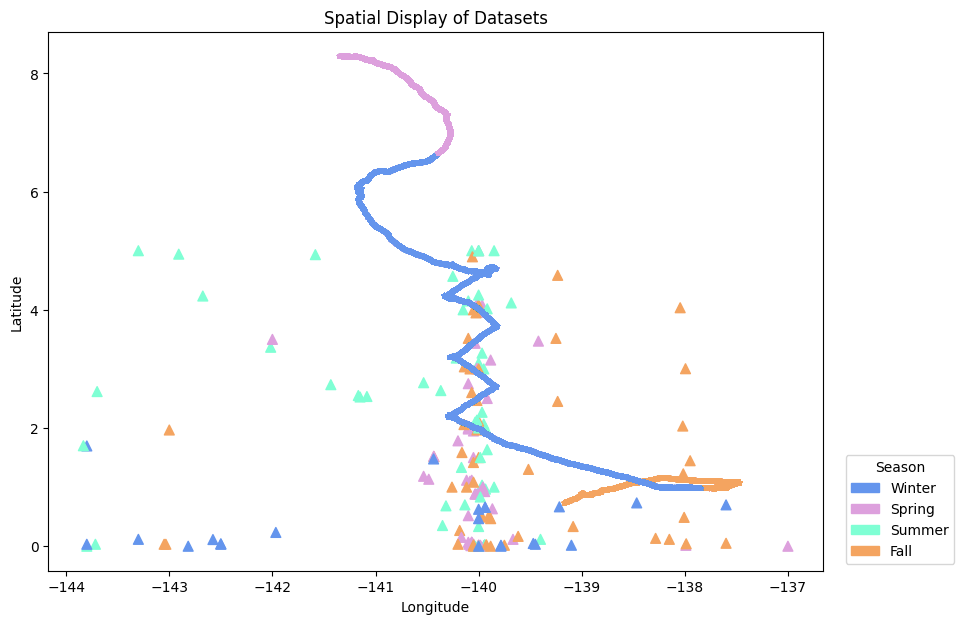

In [13]:
# SPATIAL/TEMPORAL COMPARISON PLOT
# Extract latitude and longitude
lat1 = np.array(historic_ds1['lat'])
lon1 = np.array(historic_ds1['lon'])

lat2 = np.array(historic_ds2['lat'])
lon2 = np.array(historic_ds2['lon'])



# Create a single figure with both datasets
plt.figure(figsize=(10, 7))
cmap = mcolors.ListedColormap(['cornflowerblue', 'cornflowerblue', 'plum', 'plum', 'plum', 'aquamarine', 'aquamarine', 'aquamarine', 'sandybrown', 'sandybrown', 'sandybrown', 'cornflowerblue'])

# Plot first dataset
plt.scatter(lon1, lat1, s=50, marker = '^', c = months1, cmap=cmap, label='1950-1984 CTD Casts')
plt.scatter(lon2, lat2, s=50, marker = '^', c = months2, cmap=cmap)

# Plot second dataset
plt.scatter(lon, lat, marker = '*', c = sg_months, s = 10, cmap=cmap, label='2024-2025 Seaglider Track')

# plot details
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title('Spatial Display of Datasets')
#season legend
seasons = [mpatches.Patch(color='cornflowerblue', label='Winter'), mpatches.Patch(color='plum', label='Spring'), mpatches.Patch(color='aquamarine', label='Summer'), mpatches.Patch(color='sandybrown', label='Fall')]
plt.legend(handles=seasons, title="Season", loc='lower left', bbox_to_anchor=(1.02, 0))

plt.show()

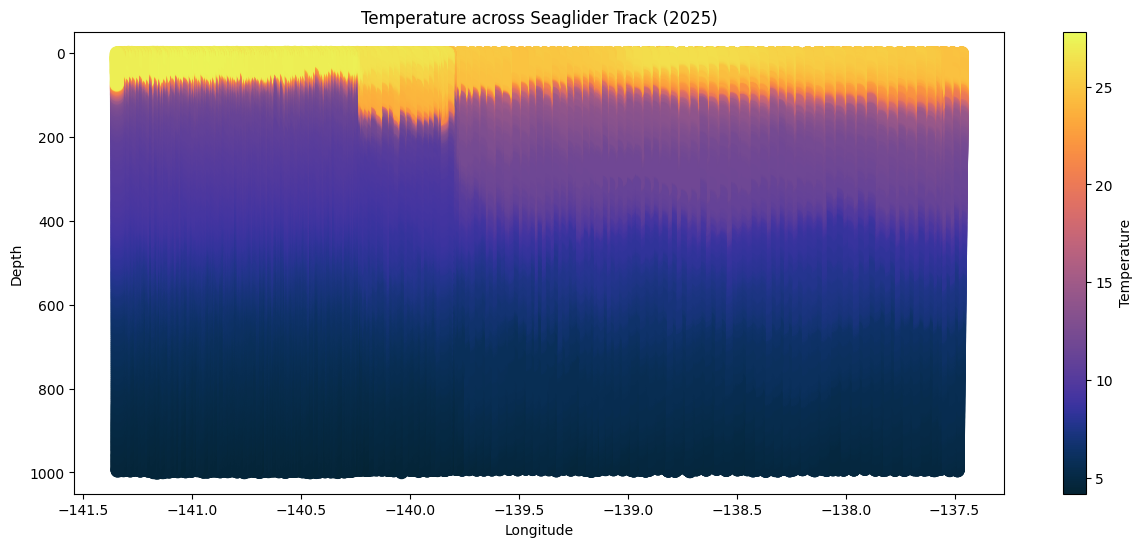

In [11]:
# variable plot
# can use this to plot any variable from the seaglider dataset, I just chose temperture
plt.figure(figsize=(15, 6))
scatter = plt.scatter(lon, depth, c=temp, cmap= cm.cm.thermal, s=80)
plt.colorbar(label="Temperature")
plt.xlabel("Longitude")
plt.ylabel("Depth")
plt.gca().invert_yaxis()

plt.title("Temperature across Seaglider Track (2025)")
plt.show()